In [9]:
from time import time

import torch
import sklearn.datasets
import sklearn.preprocessing
import sklearn.model_selection
import numpy as np
import torchvision
import torchvision.transforms as transforms
import onlinehd

from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST as FMNIST
from torchvision.datasets import EMNIST
import torchvision.transforms as transforms

import pandas as pd
import pickle
from onlinehd import CAE

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets
# import pdb
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import tkinter

In [10]:
SEED = 1234
np.random.seed(SEED)
torch.manual_seed(SEED)

In [11]:
def loss_function(W, x, recons_x, h, lam):
    """Compute the Contractive AutoEncoder Loss
    Evalutes the CAE loss, which is composed as the summation of a Mean
    Squared Error and the weighted l2-norm of the Jacobian of the hidden
    units with respect to the inputs.
    Args:
        `W` (FloatTensor): (N_hidden x N), where N_hidden and N are the
          dimensions of the hidden units and input respectively.
        `x` (Variable): the input to the network, with dims (N_batch x N)
        recons_x (Variable): the reconstruction of the input, with dims
          N_batch x N.
        `h` (Variable): the hidden units of the network, with dims
          batch_size x N_hidden
        `lam` (float): the weight given to the jacobian regulariser term
    Returns:
        Variable: the (scalar) CAE loss
    """
    mse = mse_loss(recons_x, x)
    # Since: W is shape of N_hidden x N. So, we do not need to transpose it as
    # opposed to #1
    dh = h * (1 - h) # Hadamard product produces size N_batch x N_hidden
    # Sum through the input dimension to improve efficiency, as suggested in #1
    w_sum = torch.sum(Variable(W)**2, dim=1)
    # unsqueeze to avoid issues with torch.mv
    w_sum = w_sum.unsqueeze(1) # shape N_hidden x 1
    contractive_loss = torch.sum(torch.mm(dh**2, w_sum), 0)
    return mse + contractive_loss.mul_(lam)

In [12]:
def CAEtrain(epoch, loader, recon, lam : float = 1e-4):
    model.train()
    train_loss = 0

    for idx, (data, _) in enumerate(loader):
        data = Variable(data)
        if args.cuda:
            data = data.cuda()
        optimizer.zero_grad()
        hidden_representation, recons_x = model(data)
        # Get the weights
        W = model.state_dict()['fc1.weight']

        loss = loss_function(W, data.view(-1, 784), recons_x,
                            hidden_representation, lam)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if idx%100==0:
            print(loss.data[0]/len(data))
        recon = model.save_data(data, epoch, idx, recon)

    return recon
    

In [13]:
def load_emnist():
    download_root = 'data/emnist_dataset'
    
    temp = EMNIST(download_root, split = 'letters', train=True, download=True)
    x = temp.data.unsqueeze(3).numpy().transpose((0,2,1,3))
    y = temp.targets.numpy() - 1
    temp = EMNIST(download_root, split='letters', train=False, download=True)
    x_test = temp.data.unsqueeze(3).numpy().transpose((0,2,1,3))
    y_test = temp.targets.numpy() - 1
    
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).long()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).long()
    
    x_test = x_test.float()
    y_test = y_test.long().squeeze()

    if len(x.shape) != 3:
        x = x.squeeze(3)
        x_test = x_test.squeeze(3)
    
    return x, x_test, y, y_test

In [17]:
# loads simple mnist dataset
def load():
    # fetches data
    # Using minst dataset provided by sklearn
    x, x_test, y, y_test = load_emnist()
    
    x = x.reshape(-1, 784)
    x_test = x_test.reshape(-1, 784)

    # split and normalize
    scaler = sklearn.preprocessing.Normalizer().fit(x)
    x = scaler.transform(x)
    x_test = scaler.transform(x_test)

    # changes data to pytorch's tensors
    x = torch.from_numpy(x).float() 
    x_test = torch.from_numpy(x_test).float() 
    
    # preprocessing with CAE
    train_loader = DataLoader(CAE.MyDataset(x, y), batch_size=args.batch_size, shuffle=False, **kwargs)
    recon = torch.zeros(x.shape)
    mse_loss = nn.BCELoss(reduction='sum')
    for epoch in tqdm(range(5)):
        x_tmp = CAEtrain(epoch, train_loader, recon)

    return x, x_test, y, y_test, model, scaler

In [18]:
from tqdm import tqdm

args = CAE.Args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
if args.cuda:
    torch.cuda.manual_seed(args.seed)

kwargs = {'num_workers': 5, 'pin_memory': True} if args.cuda else {}

mse_loss = nn.BCELoss(reduction='sum')

model = CAE.CAE()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
if args.cuda:
    model.cuda()

In [19]:
print('Loading...')
x, x_test, y, y_test, CAE_model, scaler = load()

Loading...


  0%|                                                     | 0/5 [00:00<?, ?it/s]

tensor(543.3779)
tensor(57.1498)
tensor(52.0549)
tensor(51.1553)
tensor(50.7175)
tensor(48.3563)
tensor(47.9995)
tensor(47.8592)
tensor(48.7654)
tensor(48.0000)


 20%|████████▊                                   | 1/5 [04:31<18:04, 271.22s/it]

tensor(48.2422)
tensor(48.1074)
tensor(47.6414)
tensor(48.1736)
tensor(48.5051)
tensor(46.7687)
tensor(46.7034)
tensor(46.6507)
tensor(47.8350)
tensor(47.1743)


 40%|█████████████████▌                          | 2/5 [08:58<13:27, 269.15s/it]

tensor(47.4431)
tensor(47.3633)
tensor(47.0136)
tensor(47.5724)
tensor(47.9504)
tensor(46.2549)
tensor(46.2545)
tensor(46.1899)
tensor(47.4394)
tensor(46.8116)


 60%|██████████████████████████▍                 | 3/5 [13:26<08:56, 268.21s/it]

tensor(47.1021)
tensor(47.0023)
tensor(46.7269)
tensor(47.2796)
tensor(47.6780)
tensor(45.9948)
tensor(46.0252)
tensor(45.9495)
tensor(47.2210)
tensor(46.6081)


 80%|███████████████████████████████████▏        | 4/5 [17:52<04:27, 267.62s/it]

tensor(46.9131)
tensor(46.8040)
tensor(46.5680)
tensor(47.1161)
tensor(47.5232)
tensor(45.8470)
tensor(45.8872)
tensor(45.8245)
tensor(47.0992)
tensor(46.4971)


100%|████████████████████████████████████████████| 5/5 [22:18<00:00, 267.75s/it]


In [20]:
_, x_cae = CAE_model.forward(x)
_, x_test_cae = CAE_model.forward(x_test)

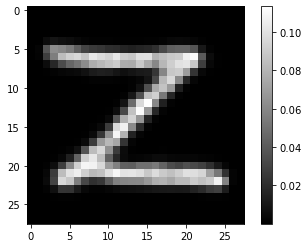

In [21]:
plt.imshow(x_test_cae[-1].detach().numpy().reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

In [22]:
x_cae = torch.from_numpy(scaler.transform(x_cae.detach().numpy())).float()
x_test_cae = torch.from_numpy(scaler.transform(x_test_cae.detach().numpy())).float()

In [23]:
classes = y.unique().size(0)
features = x.size(1)
model = onlinehd.OnlineHD(classes, features) #OnlineHD initialize

if torch.cuda.is_available():
    x = x.cuda()
    y = y.cuda()
    x_test = x_test.cuda()
    y_test = y_test.cuda()
    model = model.to('cuda')
    print('Using GPU!')

print('Training...')
t = time()
model = model.fit(x_cae, y, bootstrap=1.0, lr=0.035, epochs=300)
t = time() - t
print(f'{t = :6f}')

Training...
t = 574.512593


In [24]:
print('Validating...')
yhat = model(x_cae)
yhat_test = model(x_test_cae)

acc = (y == yhat).float().mean()
acc_test = (y_test == yhat_test).float().mean()

print(f'{acc = :6f}')
print(f'{acc_test = :6f}')

Validating...
acc = 0.688373
acc_test = 0.680962


In [26]:
import pickle

with open('hd_adversarial_sample/EMNIST_HD_FGSM.pickle', 'rb') as f:
    FGSM = pickle.load(f)

FGSM_001 = FGSM['data']['0.01']
FGSM_003 = FGSM['data']['0.03']
FGSM_007 = FGSM['data']['0.07']
FGSM_01 = FGSM['data']['0.1']

with open('hd_adversarial_sample/EMNIST_HD_DF.pickle', 'rb') as f:
    DF = pickle.load(f)

DF_data = DF['data']

with open('hd_adversarial_sample/EMNIST_HD_JSMA.pickle', 'rb') as f:
    JSMA = pickle.load(f)

JSMA_data = JSMA['data']

In [27]:
_, FGSM_001 = CAE_model.forward(FGSM_001)
_, FGSM_003 = CAE_model.forward(FGSM_003)
_, FGSM_007 = CAE_model.forward(FGSM_007)
_, FGSM_01 = CAE_model.forward(FGSM_01)
_, DF_data = CAE_model.forward(DF_data)
_, JSMA_data = CAE_model.forward(JSMA_data)

In [28]:
FGSM_001 = torch.from_numpy(scaler.transform(FGSM_001.detach().numpy().reshape(-1, 784))).float()
FGSM_003 = torch.from_numpy(scaler.transform(FGSM_003.detach().numpy().reshape(-1, 784))).float()
FGSM_007 = torch.from_numpy(scaler.transform(FGSM_007.detach().numpy().reshape(-1, 784))).float()
FGSM_01 = torch.from_numpy(scaler.transform(FGSM_01.detach().numpy().reshape(-1, 784))).float()
DF_data = torch.from_numpy(scaler.transform(DF_data.detach().numpy().reshape(-1, 784))).float()
JSMA_data = torch.from_numpy(scaler.transform(JSMA_data.detach().numpy().reshape(-1, 784))).float()

In [29]:
print('Validating...')

FGSM_001_yhat = model(FGSM_001)
FGSM_003_yhat = model(FGSM_003)
FGSM_007_yhat = model(FGSM_007)
FGSM_01_yhat = model(FGSM_01)
DF_data_yhat = model(DF_data)
JSMA_data_yhat = model(JSMA_data)

FGSM_001_acc = (y_test == FGSM_001_yhat).float().mean()
FGSM_003_acc = (y_test == FGSM_003_yhat).float().mean()
FGSM_007_acc = (y_test == FGSM_007_yhat).float().mean()
FGSM_01_acc = (y_test == FGSM_01_yhat).float().mean()
DF_acc = (y_test == DF_data_yhat).float().mean()
JSMA_acc = (y_test == JSMA_data_yhat).float().mean()

print(f'{FGSM_001_acc = :6f}')
print(f'{FGSM_003_acc = :6f}')
print(f'{FGSM_007_acc = :6f}')
print(f'{FGSM_01_acc = :6f}')
print(f'{DF_acc = :6f}')
print(f'{JSMA_acc = :6f}')

Validating...
FGSM_001_acc = 0.667548
FGSM_003_acc = 0.585144
FGSM_007_acc = 0.303077
FGSM_01_acc = 0.175769
DF_acc = 0.677740
JSMA_acc = 0.663750
